C:\Users\Admin\AppData\Local\Temp/ipykernel_15084/3694179653.py:37: RuntimeWarning: divide by zero encountered in log10
  log_energy = 10 * np.log10(energy / 1e7)


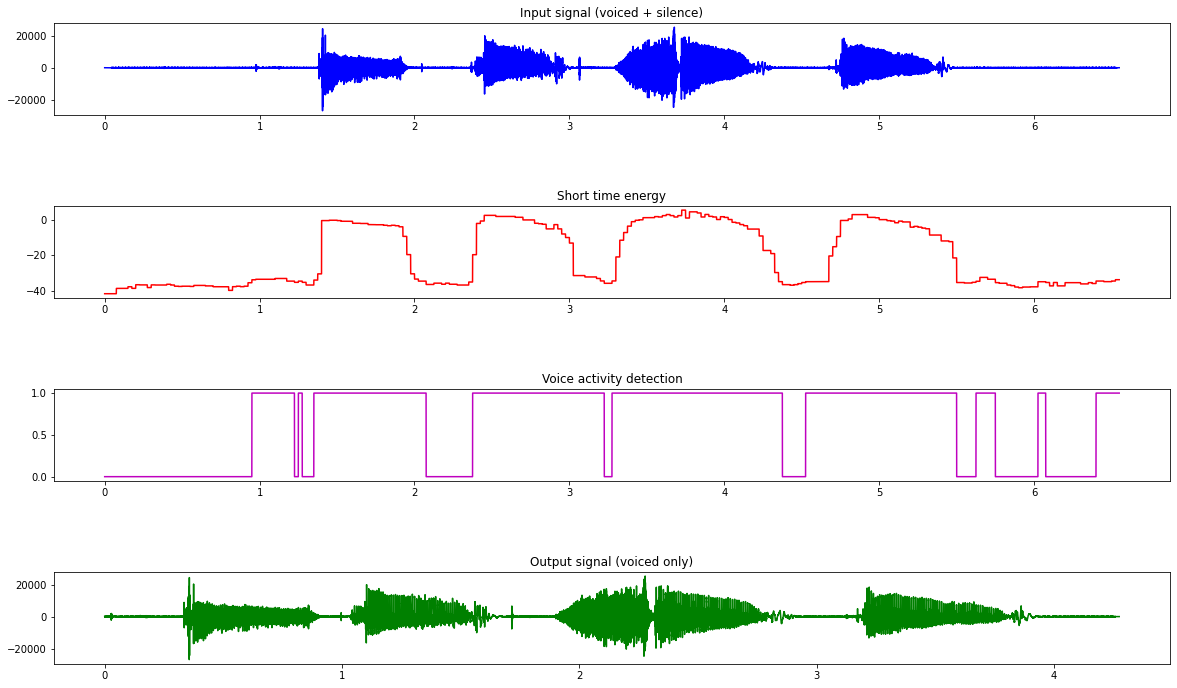

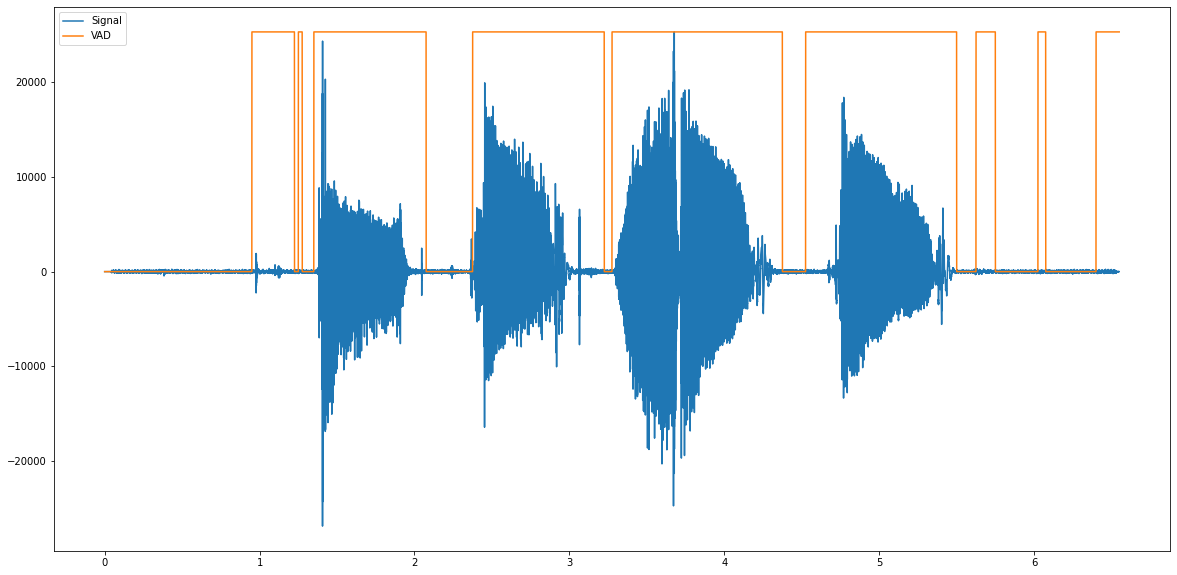

48000


In [15]:
#Nguyễn Trung Kiên - 20205090
import scipy
import numpy as np
import scipy.signal
import scipy.io.wavfile
import matplotlib.pyplot as plt

def stride(a, stride_length, stride_step):
    nrows = ((a.size - stride_length) // stride_step) + 1
    n = a.strides[0]
    return np.lib.stride_tricks.as_strided(a, shape=(nrows, stride_length), strides=(stride_step*n, n))

def framing(sig, fs, win_len, win_hop):
    if win_len < win_hop: 
        print("Win_len must be larger than win_hop.")

    # tính toán frame length, frame step
    frame_length = win_len * fs
    frame_step = win_hop * fs
    signal_length = len(sig)
    frames_overlap = frame_length - frame_step
    
    rest_samples = np.abs(signal_length - frames_overlap) % np.abs(frame_length - frames_overlap)
    pad_signal = np.append(sig, np.array([0] * int(frame_step - rest_samples) * int(rest_samples != 0.)))

    frames = stride(pad_signal, int(frame_length), int(frame_step))
    return frames, frame_length

def _calculate_normalized_short_time_energy(frames):
    return np.sum(np.abs(np.fft.rfft(a=frames, n=len(frames)))**2, axis=-1) / len(frames)**2

def naive_frame_energy_vad(sig, fs, threshold, win_len, win_hop):
    frames, frames_len = framing(sig, fs, win_len, win_hop)

    # tính short time energies cho voiced frames
    energy = _calculate_normalized_short_time_energy(frames)
    log_energy = 10 * np.log10(energy / 1e7)

    energy = scipy.signal.medfilt(log_energy, 5)
    energy = np.repeat(energy, frames_len)
    
    # tính vad và speech frames
    vad     = np.array(energy > threshold, dtype=sig.dtype)
    vframes = np.array(frames.flatten()[np.where(vad==1)], dtype=sig.dtype)
    return energy, vad, np.array(vframes, dtype=np.float64)

def multi_plots(data, titles, fs, plot_rows, step=1, colors=["b", "r", "m", "g", "b", "y"]):
    # 1
    plt.subplots(plot_rows, 1, figsize=(20, 10))
    plt.subplots_adjust(left=0.125, right=0.9, bottom=0.1, top=0.99, wspace=0.4, hspace=0.99)

    for i in range(plot_rows):
        plt.subplot(plot_rows, 1, i+1)
        y = data[i]
        plt.plot([i/fs for i in range(0, len(y), step)], y, colors[i])
        plt.gca().set_title(titles[i])
    plt.show()
    
    # 2
    sig, vad = data[0], data[-2]
    # VAD, orginal signal
    plt.subplots(1, 1, figsize=(20, 10))
    plt.plot([i/fs for i in range(len(sig))], sig, label="Signal")
    plt.plot([i/fs for i in range(len(vad))], max(sig)*vad, label="VAD")
    plt.legend(loc='best')
    plt.show()

#main
fname = "test.wav"
fs, sig = scipy.io.wavfile.read(fname)
#voiced frames
energy, vad, voiced = naive_frame_energy_vad(sig, fs, threshold=-35, win_len=0.025, win_hop=0.025)
    
multi_plots(data=[sig, energy, vad, voiced], titles=["Input signal (voiced + silence)", "Short time energy","Voice activity detection", "Output signal (voiced only)"],fs=fs,plot_rows=4, step=1)
print(fs)

314400
0.9499791666666667 1.2249791666666667 1.2499791666666666 1.2749791666666668 1.3499791666666667 2.0749791666666666 2.374979166666667 3.2249791666666665 3.2749791666666668 4.374979166666667 4.524979166666666 5.499979166666667 5.624979166666667 5.749979166666667 6.024979166666666 6.074979166666667 6.399979166666666
Start time:  0.9499791666666667
End time:  6.399979166666666


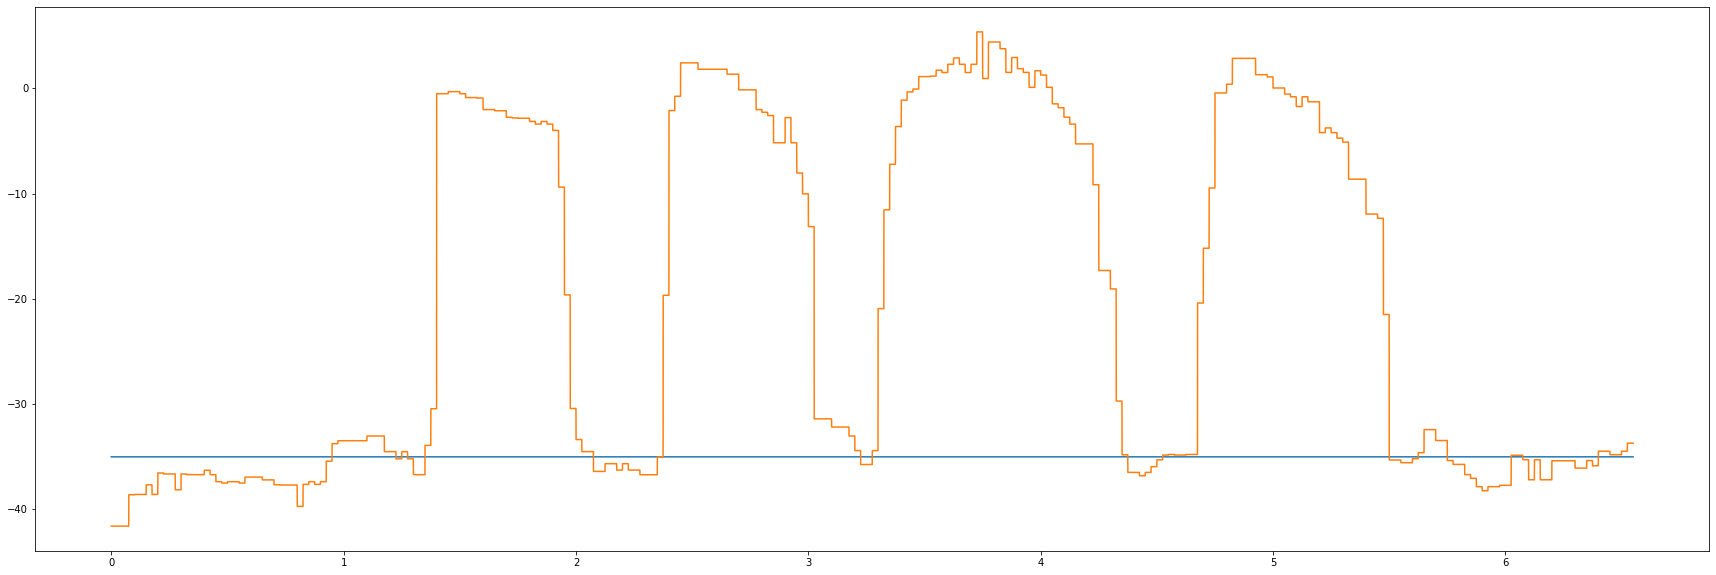

In [16]:
x = [i/fs for i in range(len(energy))]
f = [-35 for i in range(len(energy))]
plt.figure(figsize=(30,10))
plt.plot(x, f,'-')
plt.plot(x, energy,'-')
idx = np.argwhere(np.diff(np.sign(f - energy))).flatten()
print(len(energy))
print(*idx/fs)
print("Start time: ",idx[0]/fs)
print("End time: ",idx[-1]/fs)
plt.show()